## Importing dataset and libs

In [17]:
import pandas as pd
import numpy as np
import math
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

replays = pd.read_csv('../data/starcraft.csv')

In [18]:
replays.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,...,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,0.000055,0.000110,...,0.004849,32.6677,40.8673,4.7508,0.000220,0.001397,0.000047,0.0,0.000000,127448
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,0.000069,0.000294,...,0.004307,32.9194,42.3454,4.8434,0.000381,0.001194,0.000087,0.0,0.000208,57812
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,0.000042,0.000294,...,0.002926,44.6475,75.3548,4.0430,0.000231,0.000745,0.000063,0.0,0.000189,95360
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,0.000011,0.000053,...,0.003783,29.2203,53.7352,4.9155,0.000202,0.000426,0.000075,0.0,0.000384,93852
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,0.000039,0.000000,...,0.002368,22.6885,62.0813,9.3740,0.000289,0.001174,0.000077,0.0,0.000019,51936


## Dataset and research question

**Name**: StarCraft II Replay Analysis<br>
**Link**: https://www.kaggle.com/sfu-summit/starcraft-ii-replay-analysis/home<br>
**Domain**: Gaming<br>
**Context**: This dataset is an aggregate of the screen-fixations from screen movements of StarCraft 2 replay files.<br>
**Size**: 3395 rows<br>
**Motivation**: In the past i played rts games like starcraft 2 and age of empires 2. Later i also
enjoyed watching the tournaments, and videos of old tournaments. Now i sporadically watch
videos of rts games. I am always intrigued by the skills that pro players acquire. I found the
dataset by just scrolling through the kaggle datasets.


## Feature explanation

| Feature       | Description   |
| ------------- |:-------------:|
| GameID        | Unique ID for each game |
| LeagueIndex   | 1-8 for Bronze, Silver, Gold, Diamond, Master, GrandMaster,Professional leagues      |
| Age           | Real live age of player      |
| HoursPerWeek   | Hours spent playing per week      |
| TotalHours | Total hours spent playing      |
| APM   | Actions per minute      |
| SelectByHotkeys | Number of unit selections made using hotkeys per timestamp      |
| AssignToHotkeys   | Number of units assigned to hotkeys per timestamp      |
| UniqueHotkeys | Number of unique hotkeys used per timestamp  |
| MinimapAttacks   | Number of attack actions on minimal per timestamp      |
| MinimapRightClicks | Number of right-clicks on minimal per timestamp      |
| NumberOfPACs   | Number of PACs per timestamp      |
| GapBetweenPACs | Mean duration between PACs (milliseconds)      |
| ActionLatency   | Mean latency from the onset of PACs to their first action (milliseconds)      |
| ActionsInPAC | Mean number of actions within each PAC      |
| TotalMapExplored   | Number of 24x24 game coordinate grids viewed by player per timestamp      |
| WorkersMade | Number of SCVs, drones, probes trained per timestamp    |
| UniqueUnitsMade | Unique units made per timestamp    |
| ComplexUnitsMade | Number of ghosts, investors, and high templars trained per timestamp     |
| ComplexAbilityUsed | Abilities requiring specific targeting instructions used per timestamp      |
| MaxTimeStamp | Time stamp of game's last recorded event |

## Research question & plan

**How can i predict the league index for a replay analysis?**

**Cleaning**
During some discovery of the dataset i didn’t came across any problematic data quality<br>
violations. I do have to fix some formats, like change age from 23.0 -> 23.<br>
When i was given the advice to combine some of the higher leagues due to the data amount<br>
those leagues, i checked out the league index of the replays, and this confirmed the expectations see below<br>

**features**
Some features are maybe a bit redundant. I’m considering combining combining some data.<br>
Although i wanna start out without combining these.<br>

SelectByHotkeys: Number of unit selections made using hotkeys per timestamp<br>
AssignToHotkeys: Number of units assigned to hotkeys per timestamp<br>
UniqueHotkeys: Number of unique hotkeys used per timestamp<br>

These 3 features could be a ‘HotkeyBehaviour’ score.<br>

MinimapAttacks: Number of attack actions on minimal per timestamp MinimapRightClicks:<br>
Number of right-clicks on minimal per timestamp<br>

These 2 could be a ‘MinimapBehaviour’ score.<br>

**algorithms**

# Cleaning

In [3]:
# deleting one row with 1 million hours of playtime
replays = replays[replays['TotalHours'] != 1000000]

replays.dropna(inplace=True)
replays.isnull().values.any()

replays.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,...,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
count,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,...,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000
mean,4719.426131,4.120467,21.651483,15.907102,661.039257,114.525764,0.004017,0.000364,0.000058,0.000094,...,0.003433,40.717594,64.218000,5.266780,0.000282,0.001031,0.000085,0.000060,0.000142,83748.656877
std,2657.307846,1.448307,4.206512,11.965468,856.348806,48.032308,0.004715,0.000210,0.000038,0.000159,...,0.000965,17.058352,19.034036,1.500796,0.000086,0.000520,0.000025,0.000112,0.000266,33612.702540
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,...,0.000679,6.666700,24.632600,2.038900,0.000091,0.000077,0.000020,0.000000,0.000000,25224.000000
25%,2423.000000,3.000000,19.000000,8.000000,300.000000,79.229400,0.001244,0.000202,0.000032,0.000000,...,0.002743,29.328700,50.929400,4.261500,0.000224,0.000682,0.000068,0.000000,0.000000,60116.000000
50%,4787.000000,4.000000,21.000000,12.000000,500.000000,107.067600,0.002444,0.000349,0.000053,0.000039,...,0.003376,37.060500,61.303300,5.086800,0.000269,0.000904,0.000082,0.000000,0.000021,81044.000000
75%,6995.000000,5.000000,24.000000,20.000000,800.000000,140.090400,0.004938,0.000493,0.000078,0.000114,...,0.004003,48.512000,74.032800,6.027500,0.000324,0.001258,0.000099,0.000087,0.000182,102156.000000
max,9271.000000,7.000000,44.000000,168.000000,25000.000000,389.831400,0.043088,0.001648,0.000338,0.003019,...,0.007971,237.142900,176.372100,18.558100,0.000832,0.005149,0.000202,0.000902,0.003084,388032.000000


## LeagueIndex spread

Text(0,0.5,'Amount of replays')

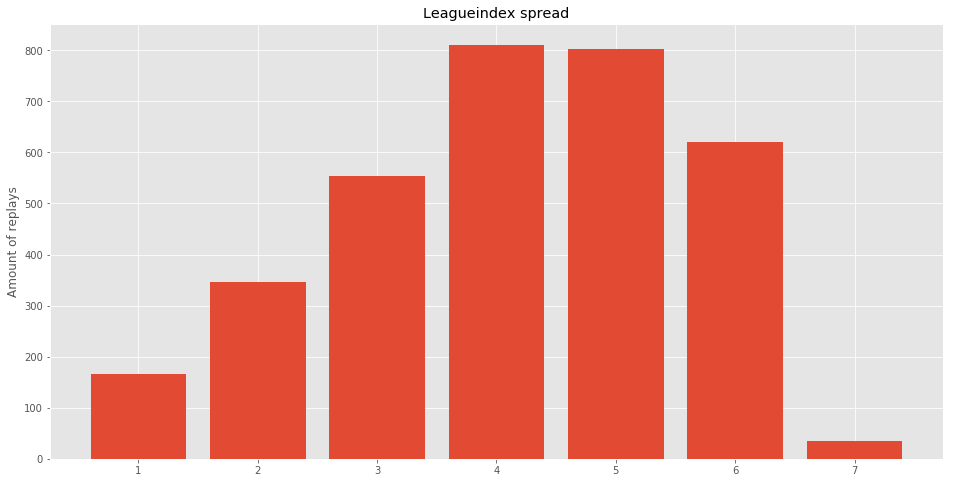

In [4]:
plt.figure(figsize=(16, 8));

leagueCounts = replays['LeagueIndex'].value_counts().sort_index()

labels = leagueCounts.index.values.tolist()
y_pos = np.arange(len(labels))

# print(leagueCounts)
# print(replays.groupby('LeagueIndex').count())

plt.bar(y_pos, leagueCounts, align='center', alpha=1)
plt.xticks(y_pos, labels)

plt.title('Leagueindex spread')
plt.ylabel('Amount of replays')


## Combining LeagueIndexes

Text(0,0.5,'Amount of replays')

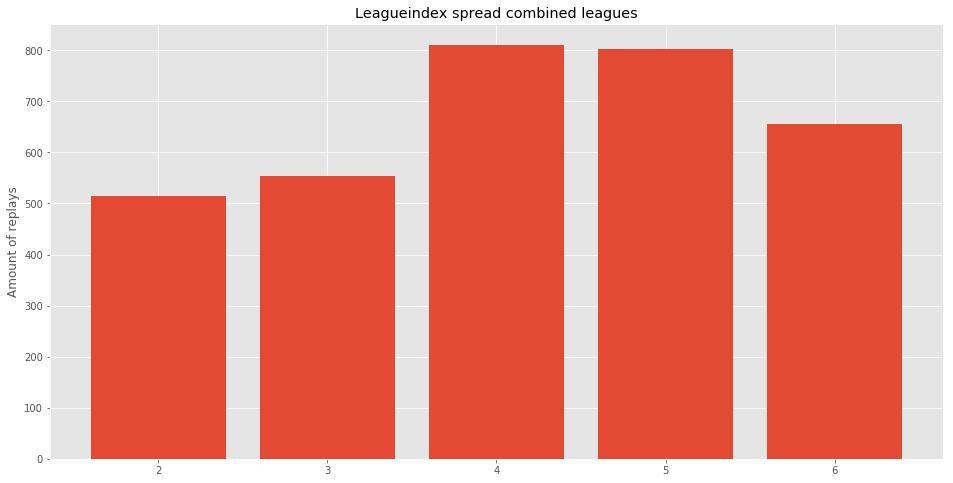

In [5]:
replays.loc[replays['LeagueIndex'] == 1, 'LeagueIndex'] = 2
replays.loc[replays['LeagueIndex'] == 7, 'LeagueIndex'] = 6

leagueCounts = replays['LeagueIndex'].value_counts().sort_index()
labels = leagueCounts.index.values.tolist()
y_pos = np.arange(len(labels))

plt.figure(figsize=(16, 8));
plt.bar(y_pos, leagueCounts, align='center', alpha=1)
plt.xticks(y_pos, labels)
plt.title('Leagueindex spread combined leagues')
plt.ylabel('Amount of replays')

# Plotting LeagueIndex against other features

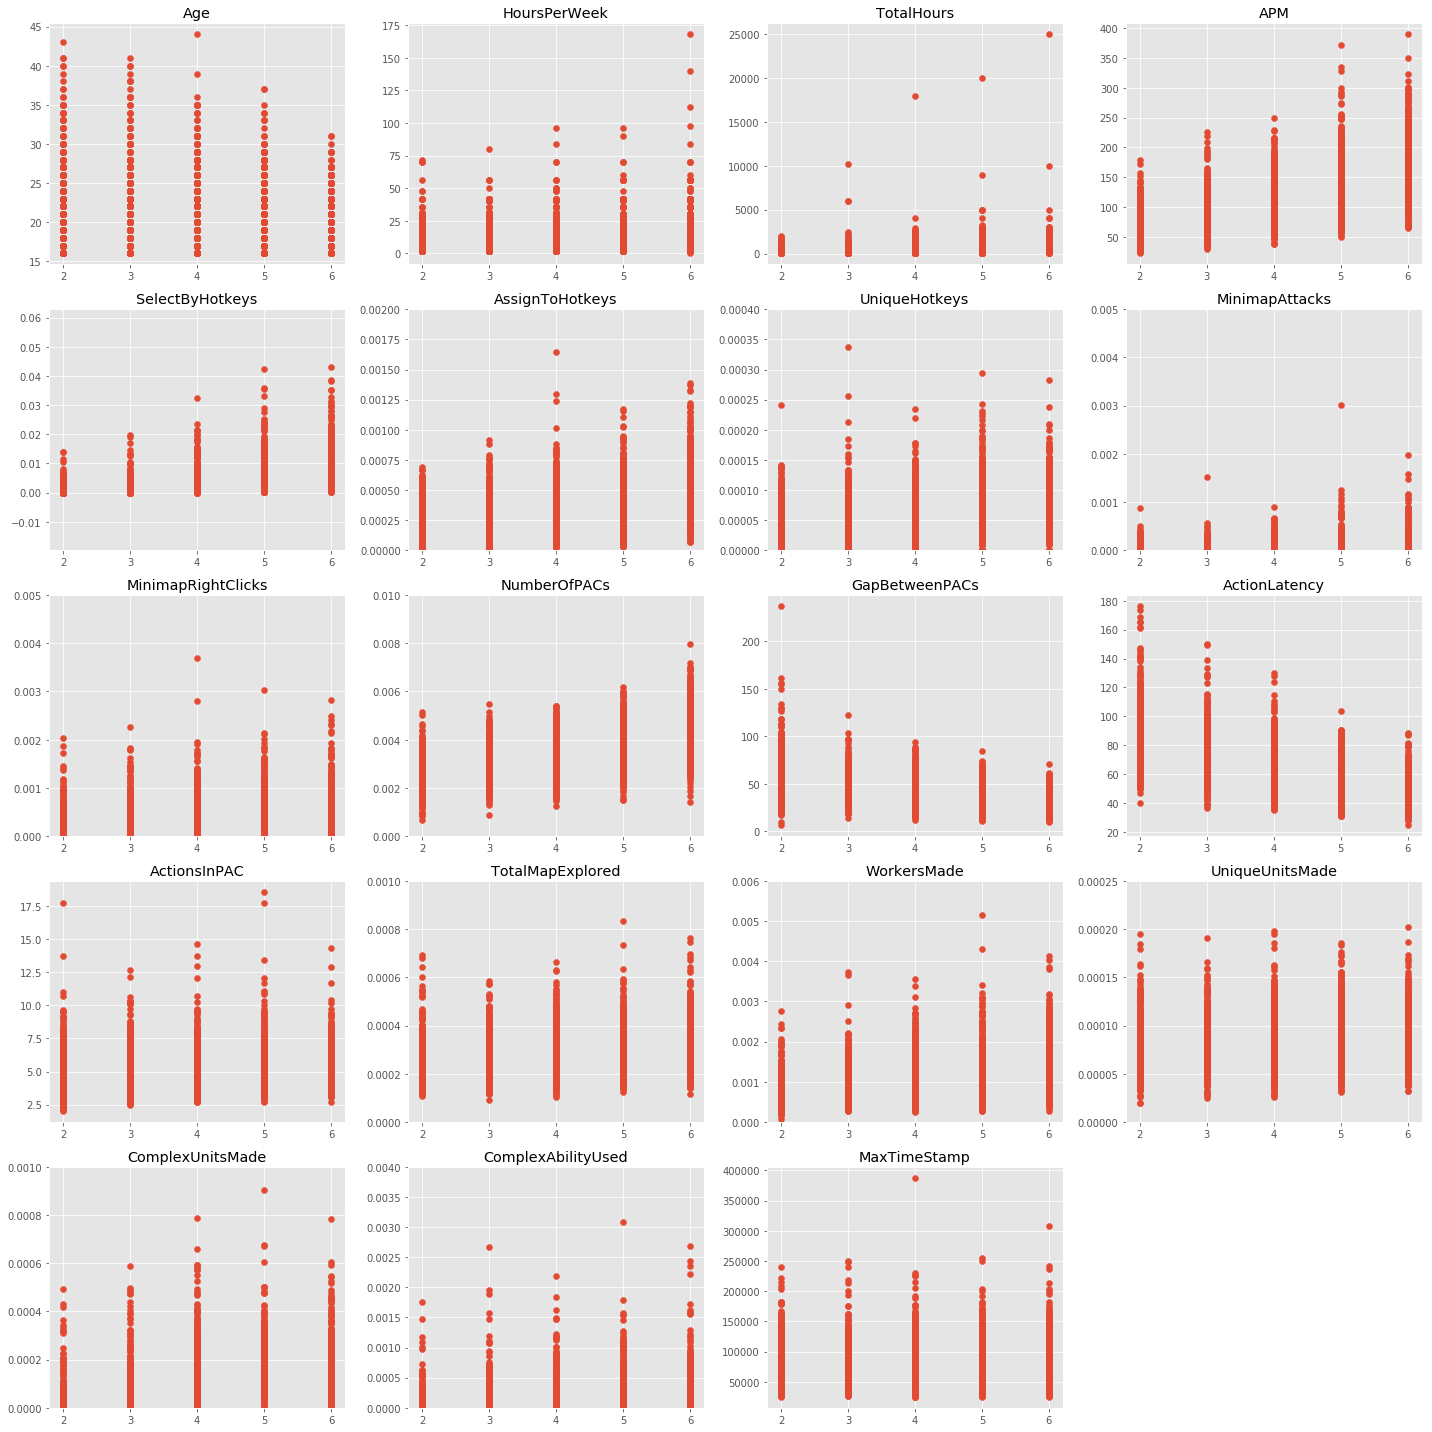

In [6]:

plt.figure(figsize=(20, 20))
graphs = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 
          'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 
          'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
         'ComplexAbilityUsed', 'MaxTimeStamp']
index = 0
for  graph in graphs:
    plt.subplot(5, 4, index + 1)
    plt.title(graph)
    plt.scatter(replays.LeagueIndex, replays[graph])
    plt.xticks([2, 3, 4, 5, 6])
        
    if(graph == 'ComplexAbilityUsed'):
        plt.ylim([0.0,0.004])
    if(graph == 'ComplexUnitsMade' or graph == 'TotalMapExplored'):
        plt.ylim([0.0,0.001])
    if(graph == 'UniqueUnitsMade'):    
        plt.ylim([0.0,0.00025])
    if(graph == 'WorkersMade'):     
        plt.ylim([0.0,0.006])
    if(graph == 'NumberOfPACs'):
        plt.ylim([0.0,0.010])
    if(graph == 'MinimapRightClicks' or graph == 'MinimapAttacks'):
        plt.ylim([0.0,0.005])
    if(graph == 'UniqueHotkeys'):
        plt.ylim([0.0,0.0004])
    if(graph == 'AssignToHotkeys'):
        plt.ylim([0.0,0.002])
        
        
    index += 1
plt.tight_layout()

# Predicting league index

## Splitting into train and test

### All features

In [7]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(replays.iloc[:, 2:].values, replays.iloc[:, 1].values, test_size=test_size, random_state=0)

labels = replays.iloc[:, 2:].columns.values

### Specific features

In [8]:
test_size = 0.2

f1 = replays.ActionLatency.values
f2 = replays.GapBetweenPACs.values
f3 = replays.NumberOfPACs.values
f4 = replays.SelectByHotkeys.values
f5 = replays.APM.values

X_train, X_test, y_train, y_test = train_test_split(np.array(list(zip(f1, f2, f3, f4, f5))), replays.iloc[:, 1].values, test_size=test_size, random_state=0)

### Normalize/standardize

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Feature selection

In [12]:
reg = LinearRegression()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)
r_square = reg.score(X_test, y_test)
print(r_square)
coefficients = list(zip(labels, reg.coef_))

plt.figure(figsize=(16, 8));
# plt.scatter(reg.coef_, labels)


0.49350612919901593


<Figure size 1152x576 with 0 Axes>

## Feature combining?

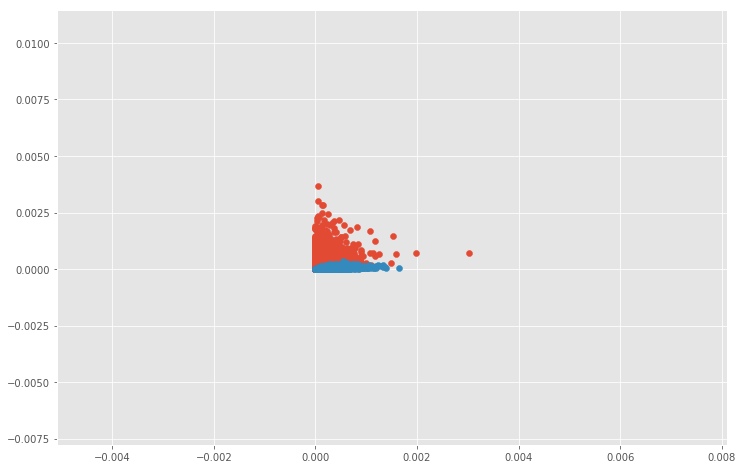

In [13]:
plt.figure(figsize=(12, 8));

plt.scatter(replays.MinimapAttacks, replays.MinimapRightClicks)
plt.scatter(replays.AssignToHotkeys, replays.UniqueHotkeys)

## Linear Support Vector Machines

In [14]:
clf = SVC(random_state=0, tol=1e-5, kernel='linear')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print(acc)

0.44011976047904194


## KFold Cross Validation

In [15]:
X = np.array(list(zip(replays.Age.values, replays.HoursPerWeek.values, replays.Age.values, replays.TotalHours.values, replays.SelectByHotkeys.values, replays.AssignToHotkeys.values, 
                      replays.UniqueHotkeys.values, replays.MinimapAttacks.values, replays.MinimapRightClicks.values, replays.NumberOfPACs.values, replays.GapBetweenPACs.values, 
                      replays.ActionLatency.values, replays.ActionsInPAC.values, replays.TotalMapExplored.values, replays.WorkersMade.values, replays.UniqueUnitsMade.values,
                      replays.ComplexUnitsMade.values, replays.ComplexAbilityUsed.values, replays.MaxTimeStamp.values, replays.APM.values)))
y = np.array(list(replays.LeagueIndex.values))

kf = KFold(n_splits=2, shuffle=True)

kf.get_n_splits(X)

accuracy_scores = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    
    #Create train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Standardize data
    scaler = preprocessing.StandardScaler().fit(X_train)
    f_train = scaler.transform(X_train)
    f_test = scaler.transform(X_test)
    
    #Create model
    clf = SVC(random_state=0, tol=1e-5, kernel='linear')
    clf.fit(f_train, y_train)
    pred = clf.predict(f_test)
    
    #Check accuracy
    acc = accuracy_score(pred, y_test)
    accuracy_scores.append(acc)
    
print(accuracy_scores) 
print(reduce(lambda x, y: x + y, accuracy_scores) / len(accuracy_scores))

TRAIN: [   0    1    3 ... 3334 3335 3336] TEST: [   2    4    6 ... 3330 3331 3333]
TRAIN: [   2    4    6 ... 3330 3331 3333] TEST: [   0    1    3 ... 3334 3335 3336]
[0.4475733972438586, 0.4844124700239808]
0.4659929336339197


## KNeighborsClassifier

([<matplotlib.axis.XTick at 0x12b03254a90>,
 <a list of 29 Text xticklabel objects>)

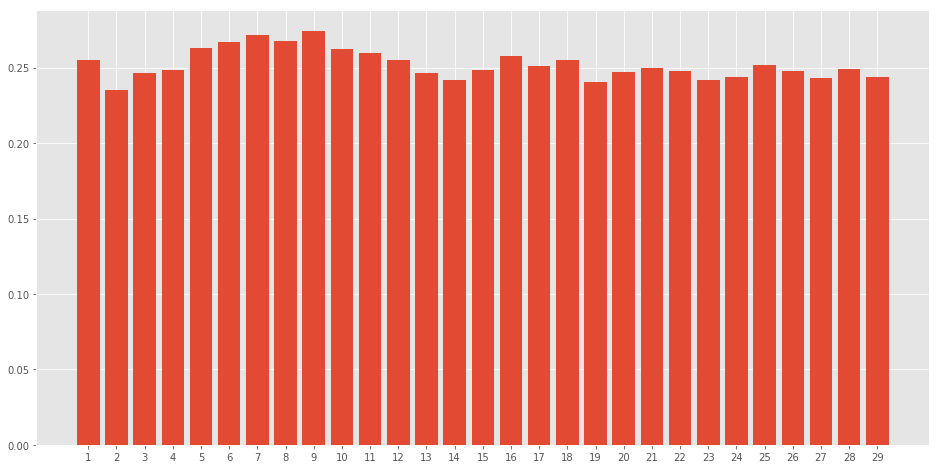

In [11]:
results = []
labels = []
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    results.append(knn.score(X_test, y_test))
    labels.append(i)
y_pos = np.arange(len(labels))
plt.figure(figsize=(16, 8));
plt.bar(y_pos, results, align='center', alpha=1)
plt.xticks(y_pos, labels)    